In [218]:
#ライブラリ、モジュールのインポート
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.font_manager as fm
import geopandas as gpd
from geopy.geocoders import Nominatim
from shapely.geometry import Point
import re
#import xml.etree.ElementTree as ET

In [219]:

# # Excelファイルの読み込み(公園データと)
# file_path = '/home/yasumasa-tezuka/intern_data/140007_park_(神奈川県公園データ).xlsx'  
# df = pd.read_excel(file_path)

# # 住所から市区町村名を抽出するカスタマイズされた関数
# def extract_municipality_custom(address):
#     if pd.isna(address) or not isinstance(address, str):
#         return ''
#     # 神奈川県の部分を削除
#     address = address.replace('神奈川県', '')
#     # 特定の市の場合は区までの記述にする
#     for special_city in ['横浜市', '川崎市', '相模原市']:
#         if special_city in address:
#             split_address = address.split('区')
#             if len(split_address) > 1:
#                 return split_address[0] + '区'
#             break
#     # 通常の市区町村名の抽出
#     for keyword in ['市', '町', '村']:
#         if keyword in address:
#             return address.split(keyword)[0] + keyword
#     return address

# # D列の住所を変換してE列に保存
# df['市区町村'] = df['住所'].apply(extract_municipality_custom)

# # 変更をExcelファイルに保存
# output_path = '/home/yasumasa-tezuka/intern_data/140007_park_(神奈川県公園データ)_修正版.xlsx'  
# df.to_excel(output_path, index=False)


In [220]:
#Excelデータのパスを指定
#公園種別、所在地、面積、設備
file_path_1 = '/home/yasumasa-tezuka/intern_data/140007_park_(神奈川県公園データ)_修正版.xlsx'
# #人口密度
file_path_2 = '/home/yasumasa-tezuka/intern_data/jinkotosetai_r5_10.xlsx'
# #行政区域の面積
file_path_3 = '/home/yasumasa-tezuka/intern_data/administrative_area.xlsx'
#フォントのパス
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc' 

In [221]:
# 公園データの読み込み
park_data = pd.read_excel(file_path_1)
#公園データの欠損値
#人口密度,人口総数
population_density = pd.read_excel(file_path_2)
#行政区域面積
administrative_area = pd.read_excel(file_path_3)

In [222]:
#公園データの情報と欠損値
# print(park_data.info())
# 各列の欠損値
missing_values = park_data.isnull().sum()
print(missing_values)

No.                  1
都道府県名                1
名称                   1
住所                   2
市区町村                 2
公園面積                 1
公園種別                 1
トイレ                  0
多目的トイレ               1
水飲み・手洗い              1
スプリング遊具・スイング遊具       4
砂場                   4
複合遊具                 4
健康器具                 5
ブランコ                 4
すべり台                 4
ジャングルジム              4
鉄棒                   4
シーソー                 4
ターザンロープ              4
ローラースライダー         6762
ふわふわドーム           6767
芝生広場              6761
水遊び               6765
ランニングコース          6766
テニスコート            6765
バスケットゴール          6747
野球場               6766
フットサル場            6767
サッカー場             6768
スケートパーク           6767
プール               6754
体育館               6767
陸上競技場             6767
ウサギ・モルモット         6767
ハムスター             6767
ひよこ               6767
馬・ポニー             6767
カフェ・飲食施設          6769
売店                6767
自動販売機             6757
バーベキュー場           6767
ドッグラン             6766
喫煙所        

In [223]:
# 面積列を数値型に変換し、NaNを削除（あるいは別の値で置き換え）
park_data['公園面積'] = pd.to_numeric(park_data['公園面積'], errors='coerce')
park_data.dropna(subset=['公園面積'], inplace=True)  # NaNを含む行を削除

# 公園のカテゴリを定義（例：小規模＜1000平方メートル、中規模＜10000平方メートル、大規模≥10000平方メートル）
def categorize_park(area):
    if area < 1000:
        return '小規模'
    elif area < 10000:
        return '中規模'
    else:
        return '大規模'
    
# 各公園にカテゴリを割り当てる
park_data['カテゴリ'] = park_data['公園面積'].apply(categorize_park)

# カテゴリ別に公園の数を集計
category_counts = park_data['カテゴリ'].value_counts()

# 結果を表示
print(category_counts)

カテゴリ
小規模    3855
中規模    3469
大規模     705
Name: count, dtype: int64


In [224]:
# データの読み込み
park_data = pd.read_excel(file_path_1)

# 数値に変換する列のリスト
numeric_columns = ['トイレ', '多目的トイレ', '水飲み・手洗い', 'スプリング遊具・スイング遊具', '砂場', '複合遊具', '健康器具', 'ブランコ', 'すべり台', 'ジャングルジム', '鉄棒', 'シーソー', 'ターザンロープ', 'ローラースライダー', 'ふわふわドーム', '芝生広場', '水遊び', 'ランニングコース', 'テニスコート', 'バスケットゴール', '野球場', 'フットサル場', 'サッカー場', 'スケートパーク', 'プール', '体育館', '陸上競技場', 'ウサギ・モルモット', 'ハムスター', 'ひよこ', '馬・ポニー', 'カフェ・飲食施設', '売店', '自動販売機', 'バーベキュー場', 'ドッグラン', '喫煙所', 'イベント広場', '避難場所', '無料駐車場', '有料駐車場', '駐輪場']

# 対象の列のみを数値に変換
for column in numeric_columns:
    park_data[column] = pd.to_numeric(park_data[column], errors='coerce')

# 合計の計算（NaN値は無視される）
sums = park_data[numeric_columns].sum()

# 結果の出力
print(sums)


トイレ               1191.0
多目的トイレ             674.0
水飲み・手洗い           5499.0
スプリング遊具・スイング遊具    1120.0
砂場                3362.0
複合遊具              1700.0
健康器具              1002.0
ブランコ              2655.0
すべり台              2768.0
ジャングルジム            395.0
鉄棒                2270.0
シーソー               280.0
ターザンロープ             82.0
ローラースライダー           31.0
ふわふわドーム              9.0
芝生広場               107.0
水遊び                 28.0
ランニングコース            21.0
テニスコート              72.0
バスケットゴール            42.0
野球場                 76.0
フットサル場               4.0
サッカー場               21.0
スケートパーク              6.0
プール                 53.0
体育館                 13.0
陸上競技場               12.0
ウサギ・モルモット            8.0
ハムスター                1.0
ひよこ                  1.0
馬・ポニー                6.0
カフェ・飲食施設            25.0
売店                  32.0
自動販売機              161.0
バーベキュー場             16.0
ドッグラン                8.0
喫煙所                 27.0
イベント広場              31.0
避難場所               341.0
無料駐車場              126.0


In [210]:
# 公園種別のカウント
park_type_counts = park_data['公園種別'].value_counts()
park_location = park_data['市区町村'].value_counts()
print(park_type_counts)
print(park_location)

公園種別
街区公園                        6589
近隣公園                         354
その他                          300
都市緑地                         291
都市林                          137
特殊公園（風致公園、動植物公園、歴史公園、墓園）      76
地区公園（カントリーパーク）                74
緑道                            74
運動公園                          57
総合公園                          46
広域公園                          15
広場公園                          11
緩衝緑地                           2
地区公園                           2
風致公園                           2
Name: count, dtype: int64
市区町村
神奈川県横浜市           2718
神奈川県川崎市           1224
神奈川県相模原市           610
神奈川県横須賀市           536
神奈川県藤沢市            317
神奈川県鎌倉市            287
神奈川県平塚市            282
神奈川県厚木市            241
神奈川県大和市            240
神奈川県秦野市            213
神奈川県茅ヶ崎市           183
神奈川県海老名市           170
神奈川県小田原市           154
神奈川県伊勢原市           149
神奈川県綾瀬市            133
神奈川県逗子市             79
神奈川県三浦市             63
神奈川県中郡大磯町           54
神奈川県中郡二宮町           53
神奈川県三浦郡葉山町          46
神奈川県座間市  

In [211]:
# フォントプロパティを設定
font_prop = fm.FontProperties(fname=font_path)
# Matplotlibのデフォルトフォントを更新
plt.rcParams['font.family'] = font_prop.get_name()

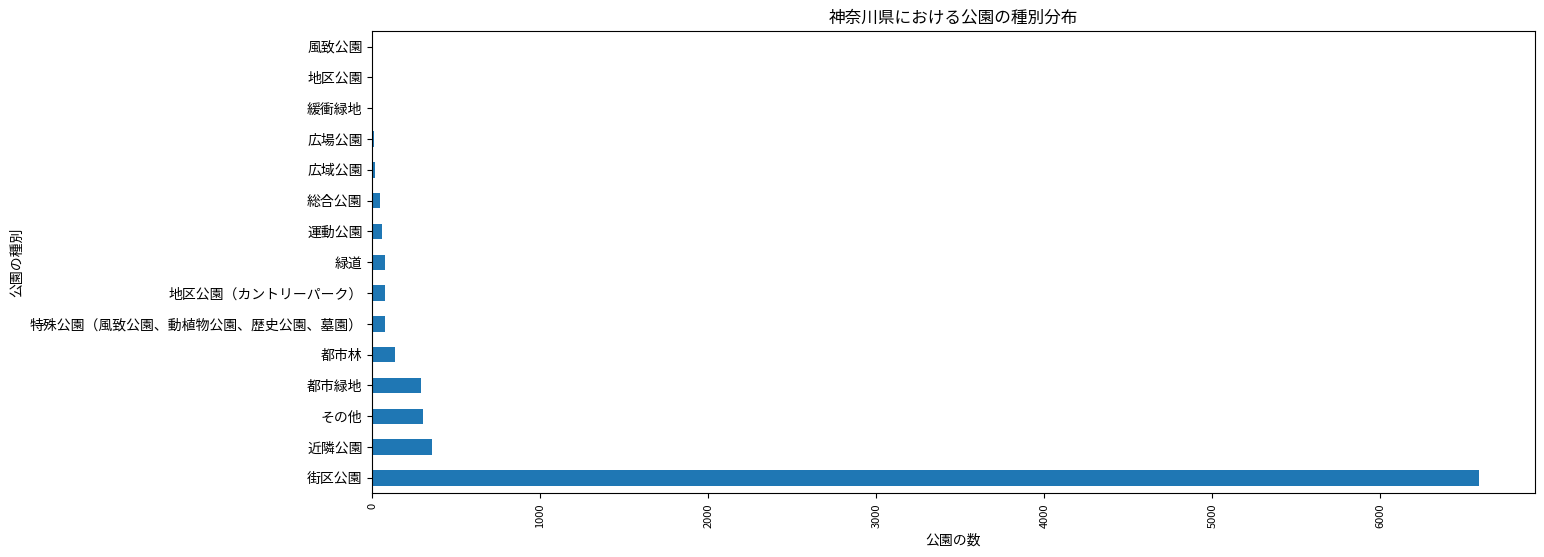

In [212]:
#神奈川県における公園の種別分布の可視化
# カテゴリ別に集計
category_counts = park_data['公園種別'].value_counts()

# グラフのサイズを設定
plt.figure(figsize=(15, 6))  # グラフのサイズを15x6インチに設定

# 横棒グラフを描画
category_counts.plot(kind='barh', stacked=True)  # 横棒グラフの描画
plt.title('神奈川県における公園の種別分布')
plt.ylabel('公園の種別')
plt.xlabel('公園の数')
plt.xticks(rotation=90, fontsize=8)
plt.show()


In [213]:
#「令和5年7月1日までの全国都道府県市区町村別の面積値」（国土地理院）https://www.gsi.go.jp/KOKUJYOHO/OLD-MENCHO-title.htmを加工して作成
#Excelファイルを読み込む
# file_path = '/home/yasumasa-tezuka/intern_data/R1_R5_all_mencho.xlsx'  # ここに元のファイルのパスを入力
# df = pd.read_excel(file_path)
# print(df.columns)
# # 特定の行と列を選択（例：1行目から5行目まで、列'A'と'B'）
# selected_data = df.loc[885:960, ['都道府県','市区町村', '令和5年7月1日(k㎡)']]

# # 選択したデータを新しいExcelファイルに保存
# selected_data.to_excel('area.xlsx', index=False)

In [214]:
from geopy.geocoders import Nominatim
from shapely.geometry import Point
import geopandas as gpd

from geopy.exc import GeocoderTimedOut

def get_coordinates(address, attempt=1, max_attempts=3):
    geolocator = Nominatim(user_agent="your_app_name", timeout=10)  # タイムアウトを延長
    try:
        location = geolocator.geocode(address)
        if location:
            return Point(location.longitude, location.latitude)
        else:
            return None
    except GeocoderTimedOut:
        if attempt <= max_attempts:
            return get_coordinates(address, attempt + 1, max_attempts)
        return None

In [217]:
# 公園データの読み込み
file_path_1 = '/home/yasumasa-tezuka/intern_data/(神奈川県公園データ)_短縮版.xlsx'
park_data = pd.read_excel(file_path_1)
# #人口密度
file_path_2 = '/home/yasumasa-tezuka/intern_data/jinkotosetai_r5_10.xlsx'
# #行政区域の面積
file_path_3 = '/home/yasumasa-tezuka/intern_data/administrative_area.xlsx'

#公園データの集計
# 公園面積のデータを数値に変換（数値以外の値はNaNに置き換え）
park_data['公園面積'] = pd.to_numeric(park_data['公園面積'], errors='coerce')

# NaNを0で置き換え
park_data['公園面積'] = park_data['公園面積'].fillna(0)

# 各市区町村ごとに公園の数と面積の合計を集計
parks_summary = park_data.groupby('市区町村').agg({'名称': 'count', '公園面積': 'sum'}).rename(columns={'名称': '公園数'})

#データの結合
# 人口密度データと市区町村エリアデータの結合
combined_data = pd.merge(population_density, administrative_area, on='市区町村', how='left')

# 結合データに公園の集計データを結合
combined_data = pd.merge(combined_data, parks_summary, on='市区町村', how='left')

# 公園の数と面積がNaNの場合を0に置換
combined_data['公園数'] = combined_data['公園数'].fillna(0)
combined_data['公園面積'] = combined_data['公園面積'].fillna(0)

#人口密度にもとづく分析
# 人口密度の中央値を計算
median_population_density = combined_data['人口密度'].median()

# 人口密度が中央値以上の地域（高密度地域）と以下の地域（低密度地域）に分ける
high_density_areas = combined_data[combined_data['人口密度'] >= median_population_density]
low_density_areas = combined_data[combined_data['人口密度'] < median_population_density]

# それぞれの地域の公園数と公園面積の平均を計算
high_density_parks_avg = high_density_areas[['公園数', '公園面積']].mean()
low_density_parks_avg = low_density_areas[['公園数', '公園面積']].mean()

# 人口密度の中央値と、高密度地域・低密度地域での公園数と公園面積の平均を表示(小数点以下2桁で表示)
print(f"人口密度の中央値: {median_population_density:.2f} 人/km²")

print("\n高密度地域の公園の状況:")
print(f"平均公園数: {high_density_parks_avg['公園数']:.2f} 個")
print(f"平均公園面積: {high_density_parks_avg['公園面積']:.2f} m²")

print("\n低密度地域の公園の状況:")
print(f"平均公園数: {low_density_parks_avg['公園数']:.2f} 個")
print(f"平均公園面積: {low_density_parks_avg['公園面積']:.2f} m²")

# 下記の分析結果から、以下の点がわかります：

# 人口密度と公園の数量:

# 人口密度が高い地域では公園の数が多い傾向があります。これは人口密度が高い地域でレクリエーションスペースや緑地の需要が高いため、より多くの公園が設置されている可能性を示唆しています。
# 人口密度と公園の面積:

# 人口密度が低い地域では、公園の平均面積が高い傾向が見られます。これは、人口密度が低い地域では土地が広く、大きな公園を設置するスペースがあるためかもしれません。

人口密度の中央値: 6343.86 人/km²

高密度地域の公園の状況:
平均公園数: 139.24 個
平均公園面積: 804239.93 m²

低密度地域の公園の状況:
平均公園数: 109.97 個
平均公園面積: 887851.03 m²


In [216]:
print(population_density.columns)
print(administrative_area.columns)
print(park_data.columns)

Index(['市区町村', '世帯', '人口総数', '人口密度'], dtype='object')
Index(['都道府県', '市区町村', '令和5年7月1日(k㎡)'], dtype='object')
Index(['No.', '都道府県名', '名称', '住所', '市区町村', '公園面積', '公園種別', 'トイレ', '多目的トイレ',
       '水飲み・手洗い', 'スプリング遊具・スイング遊具', '砂場', '複合遊具', '健康器具', 'ブランコ', 'すべり台',
       'ジャングルジム', '鉄棒', 'シーソー', 'ターザンロープ', 'ローラースライダー', 'ふわふわドーム', '芝生広場',
       '水遊び', 'ランニングコース', 'テニスコート', 'バスケットゴール', '野球場', 'フットサル場', 'サッカー場',
       'スケートパーク', 'プール', '体育館', '陸上競技場', 'ウサギ・モルモット', 'ハムスター', 'ひよこ', '馬・ポニー',
       'カフェ・飲食施設', '売店', '自動販売機', 'バーベキュー場', 'ドッグラン', '喫煙所', 'イベント広場', '避難場所',
       '無料駐車場', '有料駐車場', '駐輪場', '開園時間', '休園日', '関連リンク', '備考', '最終更新日'],
      dtype='object')


<Figure size 1000x1000 with 0 Axes>

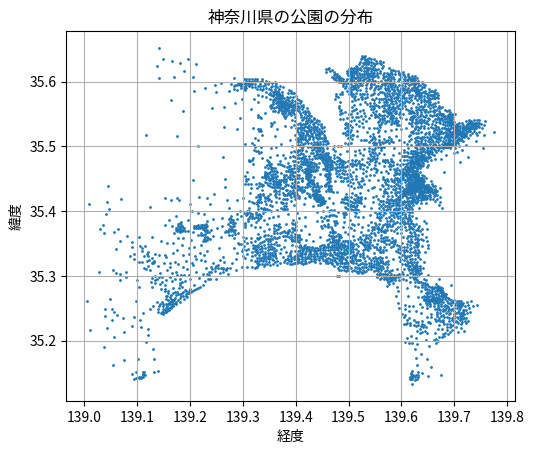

   トイレ 多目的トイレ 無料駐車場 有料駐車場  公園数
0    0      0     0     0  283
1    0      0     0     1    2
2    0      0     1     0    4
3    0      0     1     1    1
4    0      0     -     -  353
5    0      1     0     0    3
6    1      0     0     0   53
7    1      0     0     1    2
8    1      0     1     0   13
9    1      0     -     1    3
10   1      0     -     -  111
11   1      1     0     0   53
12   1      1     0     1   35
13   1      1     1     0   77
14   1      1     1     1   17
15   1      1     -     1   31
16   1      1     -     -  211
17   2      2     1     0    1
18   -      -     -     -   11


In [85]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# CSVファイルのパス
csv = '/home/yasumasa-tezuka/intern_data/公園位置情報.csv'
csv_data = pd.read_csv(csv, encoding='shift_jis')

# CSVデータから緯度と経度の列を使用してGeoDataFrameを作成
gdf = gpd.GeoDataFrame(
    csv_data, 
    geometry=gpd.points_from_xy(csv_data.経度, csv_data.緯度)
)

# CRSを設定（日本の座標系）
gdf.set_crs(epsg=4326, inplace=True)

# 公園の分布を可視化
plt.figure(figsize=(10, 10))
gdf.plot(markersize=1)
plt.title("神奈川県の公園の分布")
plt.xlabel("経度")
plt.ylabel("緯度")
plt.grid(True)
plt.show()

# Excelデータから利便設備に関する列を選択
facilities = park_data[['名称', 'トイレ', '多目的トイレ', '無料駐車場', '有料駐車場']]

# 各設備の有無に基づいてグループ化し、カウント
facility_counts = facilities.groupby(['トイレ', '多目的トイレ', '無料駐車場', '有料駐車場']).size().reset_index(name='公園数')

# 結果の表示
print(facility_counts)

# 利便設備が存在する公園の地理的分布を可視化
# ここでは例としてトイレがある公園をプロット
# toilet_available = csv_data[csv_data.市区町村名.isin(park_data[park_data['トイレ'] == 1]['名称'])]
# gdf_toilet = gpd.GeoDataFrame(
#     toilet_available, 
#     geometry=gpd.points_from_xy(toilet_available.経度, toilet_available.緯度)
# )

# # 可視化
# plt.figure(figsize=(10, 10))
# gdf_toilet.plot(markersize=2)
# plt.title("トイレがある公園の分布")
# plt.xlabel("経度")
# plt.ylabel("緯度")
# plt.grid(True)
# plt.show()


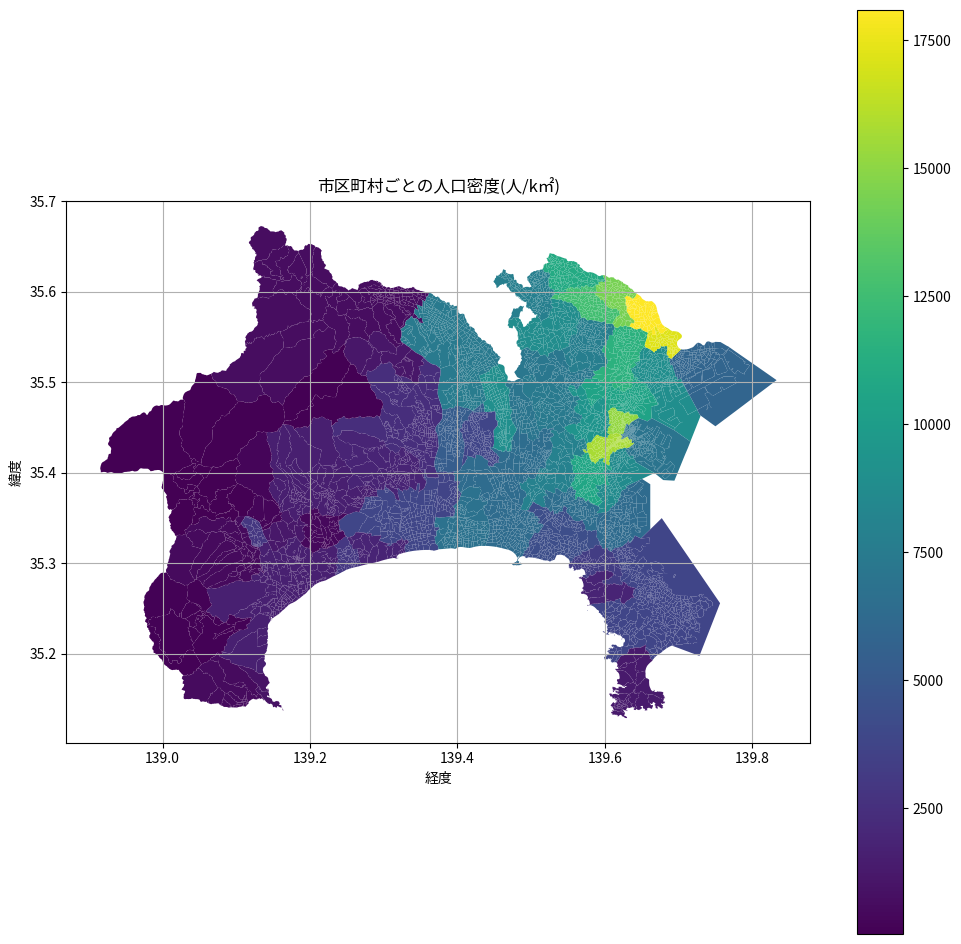

In [172]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# 市区町村の境界シェープファイルの読み込み
# boundary_file_path = '/home/yasumasa-tezuka/intern_data/境界令和4年/r2ka14.shp'  # 例: 'boundary.shp'
# boundary_gdf = gpd.read_file(boundary_file_path)

# # 境界データのプロット
# fig, ax = plt.subplots(figsize=(10, 10))
# boundary_gdf.plot(ax=ax)
# plt.title('市区町村の境界')
# plt.xlabel('経度')
# plt.ylabel('緯度')
# plt.grid(True)
# plt.show()

# #人口密度
file_path_2 = '/home/yasumasa-tezuka/intern_data/jinkotosetai_r5_10_2.xlsx'
population_density = pd.read_excel(file_path_2)

# 'CITY' 列を文字列型に変換
boundary_gdf['CITY'] = boundary_gdf['CITY'].astype(str)
population_density['CITY'] = population_density['CITY'].astype(str)

# 人口密度データを市区町村の境界データと結合
combined_gdf = pd.merge(boundary_gdf, population_density, on='CITY', how='left')

# 人口密度に基づいたマップの作成
fig, ax = plt.subplots(figsize=(12, 12))
combined_gdf.plot(ax=ax, column='人口密度', legend=True, cmap='viridis')

plt.title('市区町村ごとの人口密度(人/k㎡)')
plt.xlabel('経度')
plt.ylabel('緯度')
plt.grid(True)
plt.show()

#人口密度の上に公園の分布→失敗に終わった

In [74]:
# 各データフレームの列を確認
print("boundary_gdf columns:", boundary_gdf.columns)
print("population_density columns:", population_density.columns)

# 結合キーが正しいことを確認した後、データフレームを結合
# combined_gdf = pd.merge(boundary_gdf, population_density, on='正しい結合キー', how='left')


boundary_gdf columns: Index(['KEY_CODE', 'PREF', 'CITY', 'S_AREA', 'PREF_NAME', 'CITY_NAME',
       'S_NAME', 'KIGO_E', 'HCODE', 'AREA', 'PERIMETER', 'R2KAxx', 'R2KAxx_ID',
       'KIHON1', 'DUMMY1', 'KIHON2', 'KEYCODE1', 'KEYCODE2', 'AREA_MAX_F',
       'KIGO_D', 'N_KEN', 'N_CITY', 'KIGO_I', 'KBSUM', 'JINKO', 'SETAI',
       'X_CODE', 'Y_CODE', 'KCODE1', 'geometry'],
      dtype='object')
population_density columns: Index(['市区町村', '世帯', '人口総数', '人口密度'], dtype='object')


In [77]:
print(combined_gdf.head())
print(combined_gdf['人口密度'].describe())


  KEY_CODE PREF CITY  S_AREA PREF_NAME CITY_NAME S_NAME KIGO_E  HCODE  \
0       14   14  135  000000      神奈川県    川崎市多摩区   None   None   8101   
1       14   14  201  000000      神奈川県      横須賀市   None   None   8101   
2       14   14  201  000000      神奈川県      横須賀市   None   None   8101   
3       14   14  201  000000      神奈川県      横須賀市   None   None   8101   
4       14   14  201  000000      神奈川県      横須賀市   None   None   8101   

       AREA  ...  KBSUM  JINKO  SETAI      X_CODE     Y_CODE   KCODE1  \
0  4794.539  ...      0      0      0  139.517660  35.629611  0000-00   
1  2036.718  ...      0      0      0  139.601905  35.198251  0000-00   
2  3477.764  ...      0      0      0  139.734046  35.265660  0000-00   
3  4547.866  ...      0      0      0  139.576606  35.247812  0000-00   
4  7473.316  ...      0      0      0  139.612979  35.220595  0000-00   

                                            geometry  世帯 人口総数 人口密度  
0  POLYGON ((139.51754 35.62959, 139.51741 35.629... 

In [78]:
# `population_density` データフレームの列を確認
print(population_density.columns)

# `boundary_gdf` データフレームの列を確認
print(boundary_gdf.columns)

# 必要に応じて結合キーを修正
# combined_gdf = pd.merge(boundary_gdf, population_density, on='適切な結合キー', how='left')


Index(['CITY', '世帯', '人口総数', '人口密度'], dtype='object')
Index(['KEY_CODE', 'PREF', 'CITY', 'S_AREA', 'PREF_NAME', 'CITY_NAME',
       'S_NAME', 'KIGO_E', 'HCODE', 'AREA', 'PERIMETER', 'R2KAxx', 'R2KAxx_ID',
       'KIHON1', 'DUMMY1', 'KIHON2', 'KEYCODE1', 'KEYCODE2', 'AREA_MAX_F',
       'KIGO_D', 'N_KEN', 'N_CITY', 'KIGO_I', 'KBSUM', 'JINKO', 'SETAI',
       'X_CODE', 'Y_CODE', 'KCODE1', 'geometry'],
      dtype='object')
